Group and sum by metaprogram problem solved with: https://stackoverflow.com/questions/39650749/group-by-sparse-matrix-in-scipy-and-return-a-matrix

#### Load modules

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os

import scanpy as sc
import squidpy as sq

import scipy

from sklearn.preprocessing import LabelBinarizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
base_directory = '/n/scratch/users/s/sad167/HOPE/Xenium/'
directory = base_directory + 'analysis/neighborhood'
if not os.path.exists(directory):
    os.makedirs(directory)

In [6]:
# import metadata
metadata = pd.read_excel(base_directory+'scripts/SampleIdentifier.xlsx')
metadata = metadata[metadata['QC'] == 'PASS']
metadata = metadata[metadata['QC_downstream'] == 'PASS']

#metadata = metadata[metadata['Source'] == 'Primary']

# extract sample name and path to raw data
SampleName = metadata['SampleName'].tolist()
SampleID = metadata['Sample'].tolist()
RawDataPath = metadata['RawDataPath'].tolist()

# color palette
#metaprogram_names = ['OPC-like', 'NPC-like',  'AC-like', 'MES-like', 'Cycling',
#                    'Brain-resident', 
#                         'Endothelial',
#                         'Immune',  'Unknown']

#metaprogram_colors = ["#4B3F72FF"  ,    "#CBB3BFFF" ,     "#FFC857FF",      "#119DA4FF", 'gray',
#                      '#CF597EFF', 
#                  '#881C00FF',
#                  '#aacc00', 'silver']


metaprogram_names = ['OPC-like', 'NPC-like',  'AC-like', 'MES-like', 'Cycling',
                    'Astrocyte', 'Oligodendrocytes' ,'Neurons',
                         'Endothelial',
                         'Myeloid', 'T-cells', 'Unknown']

metaprogram_colors = ["#4B3F72FF"  ,    "#CBB3BFFF" ,     "#FFC857FF",      "#119DA4FF", 'gray',
                      '#CF597EFF', '#D98994FF', '#E5B9ADFF',
                  '#881C00FF',
                  '#aacc00', '#55a630', 'silver'
                     ]

metaprogram_to_color = dict(zip(metaprogram_names, metaprogram_colors))

anndata_list = []
for i in range(len(SampleName)):
    adata = sc.read_10x_h5(filename = base_directory + 'data/' + RawDataPath[i]+'/cell_feature_matrix.h5')
    df = pd.read_csv(base_directory + 'data/' + RawDataPath[i]+'/cells.csv.gz')

    df.set_index(adata.obs_names, inplace=True)
    adata.obs = df.copy()

    adata.obsm["spatial"] = np.array([adata.obs.x_centroid*0.325, adata.obs.y_centroid*0.325]).transpose().astype('float64')
    
    # read metadata with annotations
    anno = pd.read_csv(base_directory + 'analysis/data/cell_ID_' + SampleName[i] + '.csv', index_col = 0)

    # Replace values in the "group" column
  #  anno['data.meta.data.cell_type'].replace({'Myeloid': 'Immune', 
  #                         'T-cells': 'Immune',  
  #                         'Astrocyte': 'Brain-resident',  
  #                         'Oligodendrocytes': 'Brain-resident',  
  #                         'Neurons': 'Brain-resident',
  #                         'Cycling': 'OPC-like',
  #                        }, inplace=True)

   # if 'X' in anno.columns:
   #     anno.index = anno['X']
    
   # adata = adata[anno.index,:]
    
    adata.obs['Metaprogram'] = anno['data.meta.data.cell_type']
    adata.obs['Metaprogram'] = adata.obs['Metaprogram'].astype('category')
    adata.obs['sample'] = SampleName[i]

    # Add the color information to the AnnData object
    adata.uns['Metaprogram_colors'] = metaprogram_to_color
    
    anndata_list.append(adata)
    
    print(SampleName[i])

adata = sc.concat(anndata_list) 


A5023_1
AYAHGG3-res1_Region_1
AYAHGG3-res1_Region_2
AYAHGG3-res1_Region_3
AYAHGG3-res1_Region_4
AYAHGG3-res1_Region_5
BCH-6070-S1_Region_1
BCH-6070-S2_Region_1
CHOP73164842_1
CHOP73164842_2
CHOP73164842_3
CHOP73164844_1
CHOP73164844_2
CHOP73166761_1
CHOP73166761_2
CHOP73166761_4
CHOP73167622_1
CHOP73167622_2
CHOP73167622_3
CHOP73168851_1
CHOP73168851_2
CHOP73168851_3
CHOP73169433_1
CHOP73169433_2
CHOP73169433_3
E45693_1
E54392_1
N1054-20-1A_Region_1
N1054-20-1A_Region_2
N306719 1A_Region_1
N306719 1A_Region_2
SUDIPG50autop_1
SUDIPG50biop_1
SUDIPG50biop_2
BCH-11283-S3_Region1
BCH-11283-S3_Region2
BCH-11283-S3_Region3
BCH-11283-S3_Region4
BCH-11283-S3_Region5
BCH-11283-S3_Region6
BCH-10267-S2_Region1
BCH-10267-S2_Region2
BCH-11283-S1_Region1
BCH-11283-S1_Region2
BCH-11283-S2_Region1
BCH-11283-S2_Region2
BCH-11283-S2_Region3
BCH-11283-S2_Region4
BCH-11283-S2_Region5
BCH-11283-S2_Region6


# Dotplot marker genes

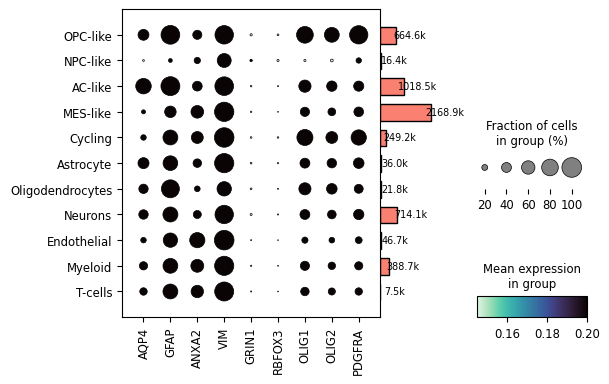

In [9]:
markers = ['AQP4', 'GFAP', 'ANXA2', 'VIM', 'GRIN1', 'RBFOX3', 'OLIG1', 'OLIG2', 'PDGFRA']

# Subset to remove "Unassigned" program 
adata = adata[~adata.obs['Metaprogram'].isin(['Unknown'])]

order_programs = ['OPC-like', 'NPC-like',  'AC-like', 'MES-like', 'Cycling',
                    'Astrocyte', 'Oligodendrocytes' ,'Neurons',
                         'Endothelial',
                         'Myeloid', 'T-cells']

# color scale
cmap_reversed = plt.get_cmap('mako').reversed()

dp = sc.pl.dotplot(adata, markers, 'Metaprogram', 
                   figsize = (6, 4), 
                   categories_order=order_programs,
                  # vmin = 0.145,
                   #vmax = 0.2,
                   return_fig = True)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5, cmap=cmap_reversed)
dp.savefig(directory+"/dotplot_fusions.pdf")

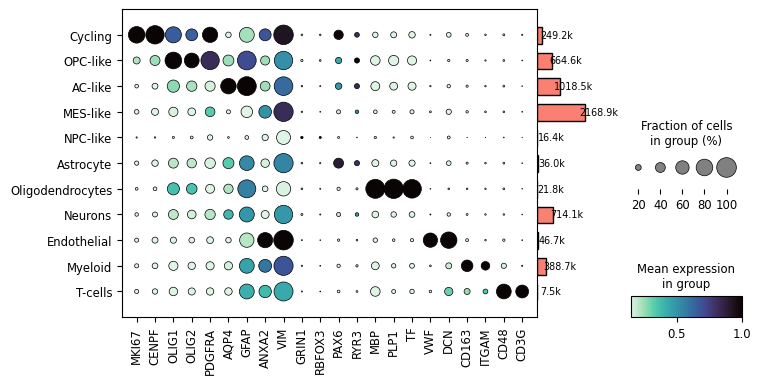

In [25]:
markers = ['MKI67', 'CENPF', 
           'OLIG1', 'OLIG2', 'PDGFRA', 
           'AQP4', 'GFAP', 
           'ANXA2', 'VIM', 
           'GRIN1', 'RBFOX3',
          'PAX6', 'RYR3',
          'MBP', 'PLP1', 'TF',
          'VWF','DCN',
          'CD163', 'ITGAM',
          'CD48', 'CD3G']


order_programs = ['Cycling', 'OPC-like', 'AC-like', 'MES-like', 'NPC-like', 
                    'Astrocyte', 'Oligodendrocytes' ,'Neurons',
                         'Endothelial',
                         'Myeloid', 'T-cells']

dp = sc.pl.dotplot(adata, markers, 'Metaprogram', 
                   figsize = (8, 4), 
                   categories_order=order_programs,
                   vmin = 0.145,
                   #vmax = 0.2,
                   standard_scale = 'var',
                   return_fig = True)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5, cmap=cmap_reversed)
dp.savefig(directory+"/dotplot_fusions.pdf")

In [ ]:
ad = adata
anndata_list = []
for sample in ad.obs['sample'].unique():
    adata_copy_int = ad[ad.obs['sample'] == sample ]
    adata_copy_int.obs.index = list(pd.DataFrame(list((adata_copy_int.obs['sample'])))[0] +'_' +pd.DataFrame(list((adata_copy_int.obs.index)))[0])
    sq.gr.spatial_neighbors(adata_copy_int, coord_type = 'generic', radius = 70.0)
    
    if len(adata_copy_int.obs.groupby('Metaprogram').size()) == 2:
        datf = pd.DataFrame(data = scipy.sparse.csr_matrix.todense((adata_copy_int.obsp['spatial_distances']>0)*1))
        datf['key'] = list(adata_copy_int.obs['Metaprogram'])
        neighmatrix = datf.groupby('key').sum().transpose()
    else:
        lb = LabelBinarizer(sparse_output=True)
        grouped = lb.fit_transform(adata_copy_int.obs['Metaprogram'].to_numpy()).T.dot((adata_copy_int.obsp['spatial_distances']>0)*1)
        neighmatrix = pd.DataFrame(data = scipy.sparse.csr_matrix.todense(grouped)).transpose()
        neighmatrix.set_axis(sorted(adata_copy_int.obs['Metaprogram'].unique()), axis = "columns", copy = False)
    
    adataneigh = sc.AnnData(neighmatrix)
    adataneigh.obs = adata_copy_int.obs
    adataneigh.obs['counts'] = list(np.sum(neighmatrix,axis=1))
    anndata_list.append(adataneigh)
    print(sample)

#### Compute centrality scores per sample

In [ ]:
centralityScore_list = []
for i in range(len(anndata_list)):
    anndata_list[i].obsm["spatial"] = np.array([anndata_list[i].obs.x_centroid*0.325, anndata_list[i].obs.y_centroid*0.325]).transpose().astype('float64')
    anndata_list[i].X = np.nan_to_num(anndata_list[i].X)
    anndata_list[i] = anndata_list[i][anndata_list[i].obs['counts'] > 6]
    anndata_list[i].raw = anndata_list[i]
    
    sq.gr.spatial_neighbors(anndata_list[i], coord_type = "generic", delaunay = True)
    sq.gr.centrality_scores(anndata_list[i], cluster_key = "Metaprogram")

    dt = anndata_list[i].uns['Metaprogram_centrality_scores']
    dt['Metaprogram'] = dt.index
    dt['Sample'] = SampleName[i]
    dt['SampleID'] = SampleID[i]
    
    centralityScore_list.append(dt)
    print(SampleName[i])

In [ ]:
## Concatenate scores
dt = pd.concat(centralityScore_list)
## Calculated average and SEM first by sample (to avoid that technical replicates have too much weight)
dt = dt.groupby(['Metaprogram', 'SampleID'], as_index=False).agg({
    'degree_centrality': ['mean'],
    'average_clustering': ['mean'],
    'closeness_centrality': ['mean']
})
dt.columns = ['Metaprogram', 'Sample',
              'degree_centrality', 'average_clustering', 'closeness_centrality']
## Now calculate average by metaprogram
dt = dt.groupby(['Metaprogram'], as_index=False).agg({
    'degree_centrality': ['mean', 'sem'],
    'average_clustering': ['mean', 'sem'],
    'closeness_centrality': ['mean', 'sem']
})

dt.columns = ['Metaprogram', 
              'degree_centrality_mean', 'degree_centrality_sem', 
              'average_clustering_mean', 'average_clustering_sem', 
              'closeness_centrality_mean', 'closeness_centrality_sem']


# remove unknown
dt = dt[~dt['Metaprogram'].str.contains('Unknown', case=False, na=False)]


## Scatter plot with error bars
plt.figure(figsize=(5, 5))
pt = sns.scatterplot(data=dt, x="average_clustering_mean", y="degree_centrality_mean", hue="Metaprogram", 
                     palette=metaprogram_to_color, 
                     legend = True, s = 100)
for i, row in dt.iterrows():
    plt.errorbar(x=row['average_clustering_mean'], y=row['degree_centrality_mean'], 
                  xerr=row['average_clustering_sem'], yerr=row['degree_centrality_sem'], 
                 fmt='o', capsize=5, color=metaprogram_to_color[row['Metaprogram']]
                )


pt.set(xlabel = 'Clustering coefficient', ylabel = 'Degree of centrality')
pt.legend(fontsize = 6)
plt.savefig(directory+f"/1_centrality_scores_averages.pdf")
plt.show()

In [ ]:
# Calculate neighborhood
nhood_list = []
for i in range(len(anndata_list)):
    sq.gr.nhood_enrichment(anndata_list[i], cluster_key = "Metaprogram", seed = 1234)
    
    df = pd.DataFrame(anndata_list[i].uns['Metaprogram_nhood_enrichment']['zscore'])
    df.index = anndata_list[i].uns['Metaprogram_centrality_scores'].index
    df.columns = anndata_list[i].uns['Metaprogram_centrality_scores'].index
    df['Programs'] = anndata_list[i].uns['Metaprogram_centrality_scores'].index

    df = pd.melt(df, id_vars='Programs')
    df['Sample'] = anndata_list[i].uns['Metaprogram_centrality_scores']['Sample'].unique()[0]
    df['SampleID'] = anndata_list[i].uns['Metaprogram_centrality_scores']['SampleID'].unique()[0]

    nhood_list.append(df)

In [ ]:
# Export as dataframes
concatenated_df = pd.concat(nhood_list, ignore_index=True)
concatenated_df.to_csv(directory+f'/2_neighborhood.csv')

In [ ]:
## Averaging metrics
dt = pd.concat(nhood_list)
dt = dt.groupby(['Programs', 'variable'], as_index=False).agg({'value': 'mean'})
dt = dt.pivot(index='Programs', columns='variable')['value']
dt.to_csv(directory+f'/2_neighborhood_average.csv')

In [ ]:
print(directory)